In [1]:
import rpy2.robjects as robj
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import numpy as np
from sklearn.metrics import top_k_accuracy_score
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import re
import warnings
import pandas as pd
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly
import pickle
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# The object that represents the R session
r = robj.r


In [2]:
%run -i '../preprocessing.py'
%run -i './dataframe_folder.py'

# Anomaly validation IDF1

In [43]:
include_idle = False
n_cycles = 685
k=10
IDF = 1

In [44]:
if IDF == 2:
    df = pd.read_csv('./cycle_dataset2.csv')


    with open('./cycle_datetimes2', 'rb') as cdts:
        cycle_datetimes = pickle.load(cdts)

    n_cycles = 1400


In [45]:
anomaly_df = pd.read_excel(f'../Notas Corretivas IDF{IDF}.xlsx', sheet_name='ENG')
anomaly_df.iloc[:, 8] = pd.to_datetime(anomaly_df.iloc[:, 8], format='%Y-%m-%d')
anomalies = anomaly_df.iloc[:, 8]
related_sensors = anomaly_df.iloc[:, 11]

In [46]:
if IDF == 1:
  start_day = '2022-01-21 00:00:00'
  end_day = '2022-02-20 23:58:00'

  start_day = pd.to_datetime(start_day, format='%Y-%m-%d %H:%M:%S')
  end_day = pd.to_datetime(end_day, format='%Y-%m-%d %H:%M:%S')

  dfCV1 = dfCV1[[x for x in dfCV1.columns if x not in deleted_features]]
  normal_df = dfCV1[dfCV1.index.to_series().between(start_day, end_day)]
else:
  start_day = '2021-12-05 00:00:00'
  end_day = '2022-02-05 23:58:00'

  start_day = pd.to_datetime(start_day, format='%Y-%m-%d %H:%M:%S')
  end_day = pd.to_datetime(end_day, format='%Y-%m-%d %H:%M:%S')

  dfCV2 = dfCV2[[x for x in dfCV2.columns if x not in deleted_features]]
  normal_df = dfCV2[dfCV2.index.to_series().between(start_day, end_day)]


normal_df.columns =[translation_dict[x] for x in normal_df.columns]
with (robj.default_converter + pandas2ri.converter).context():
  robj.globalenv['dt_val_normal'] = robj.conversion.get_conversion().py2rpy(normal_df.reset_index(drop=True))

In [7]:
def load_df_train(include_idle):
    if not include_idle:
        df_train = get_train_df(n_cycles)

    else:
        df_train = normal_df

    with (robj.default_converter + pandas2ri.converter).context():
        robj.globalenv['dt_train'] = robj.conversion.get_conversion().py2rpy(df_train)

    return df_train

In [29]:
def fit_dbn(dbn_size, alpha=None, train=True):
    if train:
        if alpha is None:
            r(f'load(file="./nets/CV1/size{dbn_size}_dmmhc_mmpc_hc_mi-g_bic-g.RDS")')
        else:
            r(f'load(file="./nets/CV{IDF}/size{dbn_size}_dmmhc_mmpc_hc_mi-g_bic-g_5e-{alpha}.RDS")')
        r(f'''
        library(dbnR)
        size <- {dbn_size}
        f_dt_train <- fold_dt(dt_train, size)
        dbn <- fit_dbn_params(net, f_dt_train, method = "mle-g")
        ''')
    else:
        r(f'load(file="./nets/CV{IDF}/size{dbn_size}_dmmhc_mmpc_hc_mi-g_bic-g_5e-{alpha}_fit.RDS")')
    r(f'''
        f_dt_val_normal <- fold_dt(dt_val_normal, {dbn_size})
        lglk_normal <- logLik(dbn, f_dt_val_normal, by.sample=TRUE, na.rm=TRUE)
        ''')
    normal_lglk = np.array(r['lglk_normal'])

    r(f'''
    decomp_loglks <- c()
    for (node in names(f_dt_val_normal)) {'{'}
        decomp_loglks <- cbind(decomp_loglks, logLik(dbn, f_dt_val_normal, by.sample=TRUE, na.rm=TRUE, by.node=TRUE, nodes=node))
    {'}'}
    ''')

    with (robj.default_converter + pandas2ri.converter).context():
        decomp_loglks = np.array(robj.conversion.get_conversion().rpy2py(robj.globalenv['decomp_loglks']))
    decomp_loglks = pd.DataFrame(decomp_loglks, columns=r('names(f_dt_val_normal)'))
 

    decomp_loglks.columns = [re.split( r'_t_(\d+)', x)[0] for x in decomp_loglks.columns]

    normal_decomp_loglks = decomp_loglks.groupby(decomp_loglks.columns, axis=1).sum()
    return normal_lglk, normal_decomp_loglks

In [9]:
def eval_anomaly(start_day):
    end_day = start_day + datetime.timedelta(days=1)
    if IDF == 1:
        slice_df = dfCV1[dfCV1.index.to_series().between(start_day, end_day)]
    else:
        slice_df = dfCV2[dfCV2.index.to_series().between(start_day, end_day)]
    
    slice_df.columns =[translation_dict[x] for x in slice_df.columns]

    
    with (robj.default_converter + pandas2ri.converter).context():
        robj.globalenv['dt_val'] = robj.conversion.get_conversion().py2rpy(slice_df.reset_index(drop=True))
    
    r(f'''
    f_dt_val <- fold_dt(dt_val, {dbn_size})
    lglk <- logLik(dbn, f_dt_val, by.sample=TRUE, na.rm=TRUE)
    ''')
        
    logl = np.array(r['lglk'])

    return logl, slice_df

In [10]:
def get_top_k_features(k, anomaly_fires_idx):
    r(f'''
    decomp_loglks <- c()
    for (node in names(f_dt_val)) {'{'}
        decomp_loglks <- cbind(decomp_loglks, logLik(dbn, f_dt_val, by.sample=TRUE, na.rm=TRUE, by.node=TRUE, nodes=node))
    {'}'}
    ''')

    with (robj.default_converter + pandas2ri.converter).context():
        decomp_loglks = np.array(robj.conversion.get_conversion().rpy2py(robj.globalenv['decomp_loglks']))
    decomp_sloglks = pd.DataFrame(decomp_loglks, columns=r('names(f_dt_val)'))
    decomp_sloglks = decomp_sloglks.iloc[anomaly_fires_idx, :]
    decomp_sloglks.columns = [re.split( r'_t_(\d+)', x)[0] for x in decomp_sloglks.columns]

    decomp_sloglks = decomp_sloglks.groupby(decomp_sloglks.columns, axis=1).sum()
    decomp_sloglks = decomp_sloglks.sum(axis=0)

    sorted_df = pd.DataFrame(decomp_sloglks.sort_values(ascending=True)[:k])

    return sorted_df

### Markov order selection (IDF1 only)

In [ ]:
anomaly_val = pd.DataFrame(columns=['anomaly_idx', 'dbn_size', 'percentile', 'lglk_threshold', 'fire', 'anom_%', 'hits'])

percentile = 3

encoder_cat = LabelEncoder()
encoder_mlb = MultiLabelBinarizer()
labels = encoder_cat.fit_transform(sorted(normal_df.columns.tolist()))
encoder_mlb.fit([sorted(normal_df.columns.tolist())])
hits_at_k = 0
df_train = load_df_train(include_idle)
for dbn_size in [2,3,4,5,6,7,8,9,10]:
    print(dbn_size)
    normal_lglk, normal_decomp_loglks = fit_dbn(dbn_size)
    
    aux = list()
    for anomaly_idx, start_day in enumerate(anomalies):
        if start_day > dfCV1.index.max():
            continue
        
        logl, slice_df = eval_anomaly(start_day)
        
        lglk_threshold = np.percentile(normal_lglk, percentile)
        logl_df = pd.DataFrame(logl.copy(), columns=['logl'])
        logl_df.loc[logl_df['logl']>=lglk_threshold, 'logl'] = 0
        logl_df.loc[logl_df['logl']<lglk_threshold, 'logl'] = 1

        anomaly_perc = len(np.nonzero(logl_df['logl'].values)[0])*100/len(logl_df['logl'])

        anomaly_fires_idx = np.nonzero(logl_df['logl'].values)[0]
        if anomaly_perc != 0:
            sorted_df = get_top_k_features(k, anomaly_fires_idx)

            formated_sensors = related_sensors[anomaly_idx].split(',')
            if formated_sensors[0] != '?':
                y_true = encoder_cat.transform(formated_sensors)
                hits_at_k = top_k_accuracy_score(y_true=y_true, y_score=encoder_mlb.transform([sorted_df.T.columns]).repeat(len(y_true), axis=0), labels=labels, k=k)
            else:
                continue

            anomaly_val = pd.concat([anomaly_val, pd.DataFrame([[anomaly_idx, dbn_size, percentile, lglk_threshold, [1 if anomaly_perc != 0 else 0][0], anomaly_perc, [hits_at_k if anomaly_perc != 0 else 0][0]]], columns=['anomaly_idx', 'dbn_size', 'percentile', 'lglk_threshold', 'fire', 'anom_%', 'hits'])])
            

    

In [ ]:
anomaly_val.columns = anomaly_val.columns.get_level_values(0)
anomaly_val = anomaly_val.reset_index(drop=True)
anomaly_val

,anomaly_idx,dbn_size,percentile,alpha,lglk_threshold,fire,anom_%,hits
0,0,6,3,2,-551.355968,1,4.888268,1.000000
1,1,6,3,2,-551.355968,1,1.256983,1.000000
2,2,6,3,2,-551.355968,1,34.497207,1.000000
3,3,6,3,2,-551.355968,1,48.324022,1.000000
4,4,6,3,2,-551.355968,1,61.871508,1.000000
...,...,...,...,...,...,...,...,...
135,28,6,3,6,-549.695925,1,100.000000,0.666667
136,29,6,3,6,-549.695925,1,100.000000,0.500000
137,30,6,3,6,-549.695925,1,100.000000,0.300000
138,31,6,3,6,-549.695925,1,100.000000,0.750000


In [ ]:
sns.set(color_codes=True, font_scale=0.8)
plt.figure(figsize=(15,5))
mean_acc = anomaly_val[(anomaly_val.anomaly_idx < 30)].groupby(by=['anomaly_idx', 'dbn_size'])['hits'].mean()*100
 
mean_acc = mean_acc.reset_index()
sns.barplot(mean_acc, y='hits', x='anomaly_idx', hue='dbn_size')
plt.xticks(np.arange(0, len(mean_acc.anomaly_idx.unique())) , [anomalies[i].strftime('%Y-%m-%d') for i in mean_acc.anomaly_idx.unique()], rotation=45)
plt.ylabel(f'Hits@{k} (%)')
plt.xlabel('Anomaly date')
L=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
L.set_title('Markov order')
for i, text in enumerate(L.get_texts()):
    text.set_text(f'{i+1}')
plt.savefig('figures/hits_at_10_mkv_order.svg', format='svg', bbox_inches = 'tight')

plt.show()

### Alpha level selection

In [11]:
anomaly_val = pd.DataFrame(columns=['anomaly_idx', 'dbn_size', 'percentile', 'alpha', 'lglk_threshold', 'fire', 'anom_%', 'hits'])

encoder_cat = LabelEncoder()
encoder_mlb = MultiLabelBinarizer()
labels = encoder_cat.fit_transform(sorted(normal_df.columns.tolist()))
encoder_mlb.fit([sorted(normal_df.columns.tolist())])
hits_at_k = 0
df_train = load_df_train(include_idle)
dbn_size = 6
percentile = 3

for alpha in ['02','03','04','05','06']:
    normal_lglk, normal_decomp_loglks = fit_dbn(dbn_size, alpha)
    
    aux = list()
    for anomaly_idx, start_day in enumerate(anomalies):
        if start_day > dfCV1.index.max():
            continue
        
        logl, slice_df = eval_anomaly(start_day)
        
        
        lglk_threshold = np.percentile(normal_lglk,percentile)
        logl_df = pd.DataFrame(logl.copy(), columns=['logl'])
        logl_df.loc[logl_df['logl']>=lglk_threshold, 'logl'] = 0
        logl_df.loc[logl_df['logl']<lglk_threshold, 'logl'] = 1

        anomaly_perc = len(np.nonzero(logl_df['logl'].values)[0])*100/len(logl_df['logl'])

        anomaly_fires_idx = np.nonzero(logl_df['logl'].values)[0]
        if anomaly_perc != 0:
            sorted_df = get_top_k_features(k, anomaly_fires_idx)

            formated_sensors = related_sensors[anomaly_idx].split(',')
            if formated_sensors[0] != '?':
                y_true = encoder_cat.transform(formated_sensors)
                hits_at_k = top_k_accuracy_score(y_true=y_true, y_score=encoder_mlb.transform([sorted_df.T.columns]).repeat(len(y_true), axis=0), labels=labels, k=k)
            else:
                continue
    
            anomaly_val = pd.concat([anomaly_val, pd.DataFrame([[anomaly_idx, dbn_size, percentile, int(alpha), lglk_threshold, [1 if anomaly_perc != 0 else 0][0], anomaly_perc, [hits_at_k if anomaly_perc != 0 else 0][0]]], columns=['anomaly_idx', 'dbn_size', 'percentile', 'alpha', 'lglk_threshold', 'fire', 'anom_%', 'hits'])])

R[write to console]: Loading required package: bnlearn

R[write to console]: 
Attaching package: ‘dbnR’


R[write to console]: The following objects are masked from ‘package:bnlearn’:

    degree, nodes, nodes<-, score


R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: In addition: 
R[write t

In [12]:
anomaly_val.columns = anomaly_val.columns.get_level_values(0)
anomaly_val = anomaly_val.reset_index(drop=True)
anomaly_val

,anomaly_idx,dbn_size,percentile,alpha,lglk_threshold,fire,anom_%,hits
0,0,6,3,2,-620.549482,1,99.301676,0.333333
1,1,6,3,2,-620.549482,1,100.000000,0.400000
2,2,6,3,2,-620.549482,1,100.000000,0.000000
3,4,6,3,2,-620.549482,1,64.525140,0.000000
4,5,6,3,2,-620.549482,1,100.000000,0.500000
...,...,...,...,...,...,...,...,...
90,18,6,3,6,-614.503497,1,100.000000,0.200000
91,19,6,3,6,-614.503497,1,100.000000,0.600000
92,20,6,3,6,-614.503497,1,100.000000,0.500000
93,21,6,3,6,-614.503497,1,100.000000,0.444444


In [ ]:
sns.set(color_codes=True, font_scale=0.8)
plt.figure(figsize=(15,5))
mean_acc = anomaly_val[(anomaly_val.anomaly_idx < 30)].groupby(by=['anomaly_idx', 'alpha'])['hits'].mean()*100
 
mean_acc = mean_acc.reset_index()
sns.barplot(mean_acc, y='hits', x='anomaly_idx', hue='alpha')
plt.xticks(np.arange(0, len(mean_acc.anomaly_idx.unique())) , [anomalies[i].strftime('%Y-%m-%d') for i in mean_acc.anomaly_idx.unique()], rotation=45)
plt.ylabel(f'Hits@{k} (%)')
plt.xlabel('Anomaly date')
L=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
L.set_title('MMPC α')
for i, text in enumerate(L.get_texts()):
    text.set_text(f'5e-{i+2}')
plt.savefig('figures/hits_at_10_alpha.svg', format='svg', bbox_inches = 'tight')

plt.show()

### Final results

In [30]:
anomaly_val = pd.DataFrame(columns=['anomaly_idx', 'dbn_size', 'percentile', 'alpha', 'lglk_threshold', 'fire', 'anom_%', 'hits'])

encoder_cat = LabelEncoder()
encoder_mlb = MultiLabelBinarizer()
labels = encoder_cat.fit_transform(sorted(normal_df.columns.tolist()))
encoder_mlb.fit([sorted(normal_df.columns.tolist())])
hits_at_k = 0
df_train = load_df_train(include_idle)
dbn_size = 6
percentile = 3

if IDF == 1:
    alpha = '06'
else:
    alpha = '04'
normal_lglk, normal_decomp_loglks = fit_dbn(dbn_size, alpha, False)

aux = list()
for anomaly_idx, start_day in enumerate(anomalies):
    if start_day > dfCV1.index.max():
        continue
    
    logl, slice_df = eval_anomaly(start_day)
    
    
    lglk_threshold = np.percentile(normal_lglk,percentile)
    logl_df = pd.DataFrame(logl.copy(), columns=['logl'])
    logl_df.loc[logl_df['logl']>=lglk_threshold, 'logl'] = 0
    logl_df.loc[logl_df['logl']<lglk_threshold, 'logl'] = 1

    anomaly_perc = len(np.nonzero(logl_df['logl'].values)[0])*100/len(logl_df['logl'])

    anomaly_fires_idx = np.nonzero(logl_df['logl'].values)[0]
    if anomaly_perc != 0:
        sorted_df = get_top_k_features(k, anomaly_fires_idx)

        formated_sensors = related_sensors[anomaly_idx].split(',')
        if formated_sensors[0] != '?':
            y_true = encoder_cat.transform(formated_sensors)
            hits_at_k = top_k_accuracy_score(y_true=y_true, y_score=encoder_mlb.transform([sorted_df.T.columns]).repeat(len(y_true), axis=0), labels=labels, k=k)
        else:
            continue

        anomaly_val = pd.concat([anomaly_val, pd.DataFrame([[anomaly_idx, dbn_size, percentile, int(alpha), lglk_threshold, [1 if anomaly_perc != 0 else 0][0], anomaly_perc, [hits_at_k if anomaly_perc != 0 else 0][0]]], columns=['anomaly_idx', 'dbn_size', 'percentile', 'alpha', 'lglk_threshold', 'fire', 'anom_%', 'hits'])])

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the firs

In [31]:
anomaly_val.columns = anomaly_val.columns.get_level_values(0)
anomaly_val = anomaly_val.reset_index(drop=True)
anomaly_val

,anomaly_idx,dbn_size,percentile,alpha,lglk_threshold,fire,anom_%,hits
0,0,6,3,4,-606.337684,1,94.832402,0.166667
1,1,6,3,4,-606.337684,1,100.000000,0.400000
2,2,6,3,4,-606.337684,1,100.000000,0.500000
3,4,6,3,4,-606.337684,1,65.363128,0.500000
4,5,6,3,4,-606.337684,1,100.000000,0.250000
5,6,6,3,4,-606.337684,1,100.000000,0.333333
6,7,6,3,4,-606.337684,1,100.000000,0.500000
7,9,6,3,4,-606.337684,1,100.000000,0.000000
8,10,6,3,4,-606.337684,1,100.000000,0.571429
9,12,6,3,4,-606.337684,1,90.769231,1.000000


In [ ]:
sns.set(color_codes=True, font_scale=0.9)
plt.figure(figsize=(20,5))
mean_acc = anomaly_val.groupby(by=['anomaly_idx'])['hits'].mean()*100
mean_acc = mean_acc.reset_index()
sns.barplot(mean_acc, y='hits', x='anomaly_idx')
plt.xticks(np.arange(0, len(anomaly_val.anomaly_idx.unique())) , [anomalies[i].strftime('%Y-%m-%d') for i in anomaly_val.anomaly_idx.unique()], rotation=45)
plt.ylabel(f'Hits@{k} (%)')
plt.xlabel('Anomaly date')
plt.title(f'IDF{IDF} results')
plt.savefig(f'figures/hits_at_10_IDF{IDF}.svg', format='svg', bbox_inches = 'tight')

plt.show()

## LGLK decomposition

In [47]:
include_idle = False

In [51]:
start_day = '2022-04-28 06:00:00'
end_day = '2022-04-28 06:44:00'

start_day = pd.to_datetime(start_day, format='%Y-%m-%d %H:%M:%S')
end_day = pd.to_datetime(end_day, format='%Y-%m-%d %H:%M:%S')

if IDF == 1:
    slice_df = dfCV1[dfCV1.index.to_series().between(start_day, end_day)]
    alpha = '06'
else:
    slice_df = dfCV2[dfCV2.index.to_series().between(start_day, end_day)]
    alpha = '04'

slice_df.columns =[translation_dict[x] for x in slice_df.columns]


with (robj.default_converter + pandas2ri.converter).context():
    robj.globalenv['dt_val'] = robj.conversion.get_conversion().py2rpy(slice_df.reset_index(drop=True))

r(f'load(file="./nets/CV{IDF}/size{dbn_size}_dmmhc_mmpc_hc_mi-g_bic-g_5e-{alpha}_fit.RDS")')
r(f'''
f_dt_val <- fold_dt(dt_val, {dbn_size})
decomp_loglks <- c()
for (node in names(f_dt_val)) {'{'}
    decomp_loglks <- cbind(decomp_loglks, logLik(dbn, f_dt_val, by.sample=TRUE, na.rm=TRUE, by.node=TRUE, nodes=node))
{'}'}
''')

with (robj.default_converter + pandas2ri.converter).context():
    decomp_loglks = np.array(robj.conversion.get_conversion().rpy2py(robj.globalenv['decomp_loglks']))
decomp_loglks = pd.DataFrame(decomp_loglks, columns=r('names(f_dt_val)'))
decomp_loglks.index = slice_df.index[dbn_size-1:]

   
    
        

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



In [52]:
max_num_variables=10

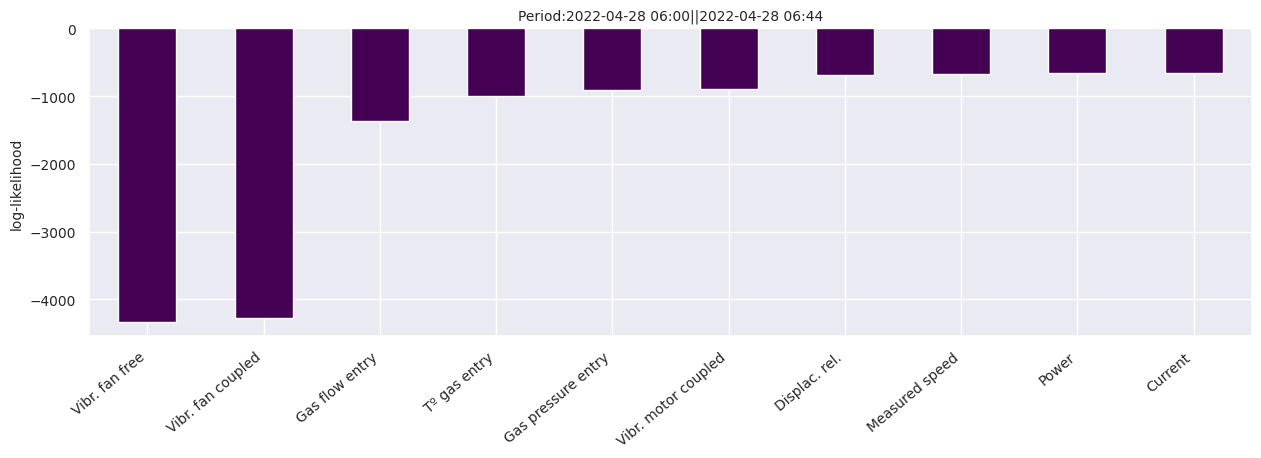

In [58]:
decomp_loglks.columns = [re.split(r'_t_(\d+)', x)[0]
                             for x in decomp_loglks.columns]
decomp_loglks = decomp_loglks.groupby(decomp_loglks.columns, axis=1).sum()

decomp_sloglks = pd.DataFrame(decomp_loglks.sum(axis=0)).T

sorted_df = decomp_sloglks.sort_values(by=0, axis=1, ascending=True).iloc[:, :max_num_variables]
ax = sorted_df.T.plot.bar(stacked=True, legend=True, cmap='viridis', rot=40, figsize=(15,4))
ax.set_xticklabels(labels=sorted_df.columns, ha='right', fontsize=10)
plt.ylabel('log-likelihood', fontsize=10)
plt.title(f"Period:" + start_day.strftime('%Y-%m-%d %H:%M||') + end_day.strftime('%Y-%m-%d %H:%M'), size=10)
ax.get_legend().remove()
plt.show()



In [67]:
decomp_loglks2 = decomp_loglks
feature = 'Vibr. fan free'
fig = make_subplots(rows=2, cols=1)

fig.append_trace(go.Scatter(
    mode='lines',
    x=decomp_loglks2.index[dbn_size:],
    y=decomp_loglks2.sum(axis=1),
    marker=dict(
        line=dict(
            width=.01
        )
    ),
    name='Overall log-likelihood'
), row=1, col=1)

fig.append_trace(go.Scatter(
    mode='lines',
    x=decomp_loglks2.index[dbn_size:],
    y=decomp_loglks2[feature],
    marker=dict(
        line=dict(
            width=.01
        )
    ),
    name=f'{feature} log-likelihood'
), row=2, col=1)

fig.update_xaxes(matches='x')
fig.update_layout(height=600, width=1400, showlegend=True)
fig.show()